<a href="https://colab.research.google.com/github/KhizarAziz/churn-prediction/blob/master/churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# get the dataset
!gdown --id 1ICZSHuGuelYu2JtldMzScUQz8Q_JNfAK

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

In [ ]:
df = pd.read_csv('/content/ready_dataset.csv',index_col=0)

# **EDA**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   userId                                              20000 non-null  object 
 1   productId                                           20000 non-null  object 
 2   model                                               19963 non-null  object 
 3   campaignId                                          20000 non-null  object 
 4   InstallDate                                         20000 non-null  object 
 5   days_since_app_installed                            20000 non-null  int64  
 6   lifetime_app_start_count                            20000 non-null  float64
 7   avg_daily_app_start                                 20000 non-null  float64
 8   days_since_last_start                               20000 non-null  float64


(churn        15083
 not_churn     4917
 Name: churn_label, dtype: int64,
 <Axes: >)

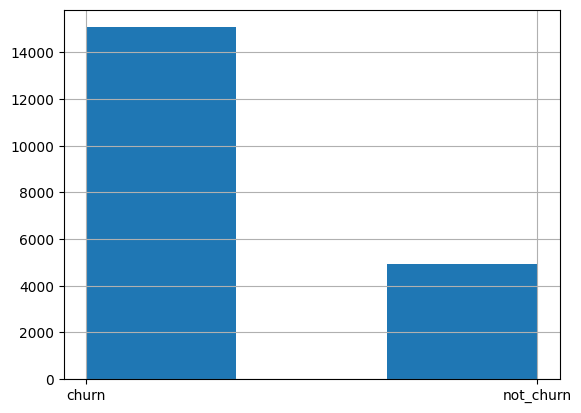

In [ ]:
df['churn_label'].value_counts(), df['churn_label'].hist(bins=3)

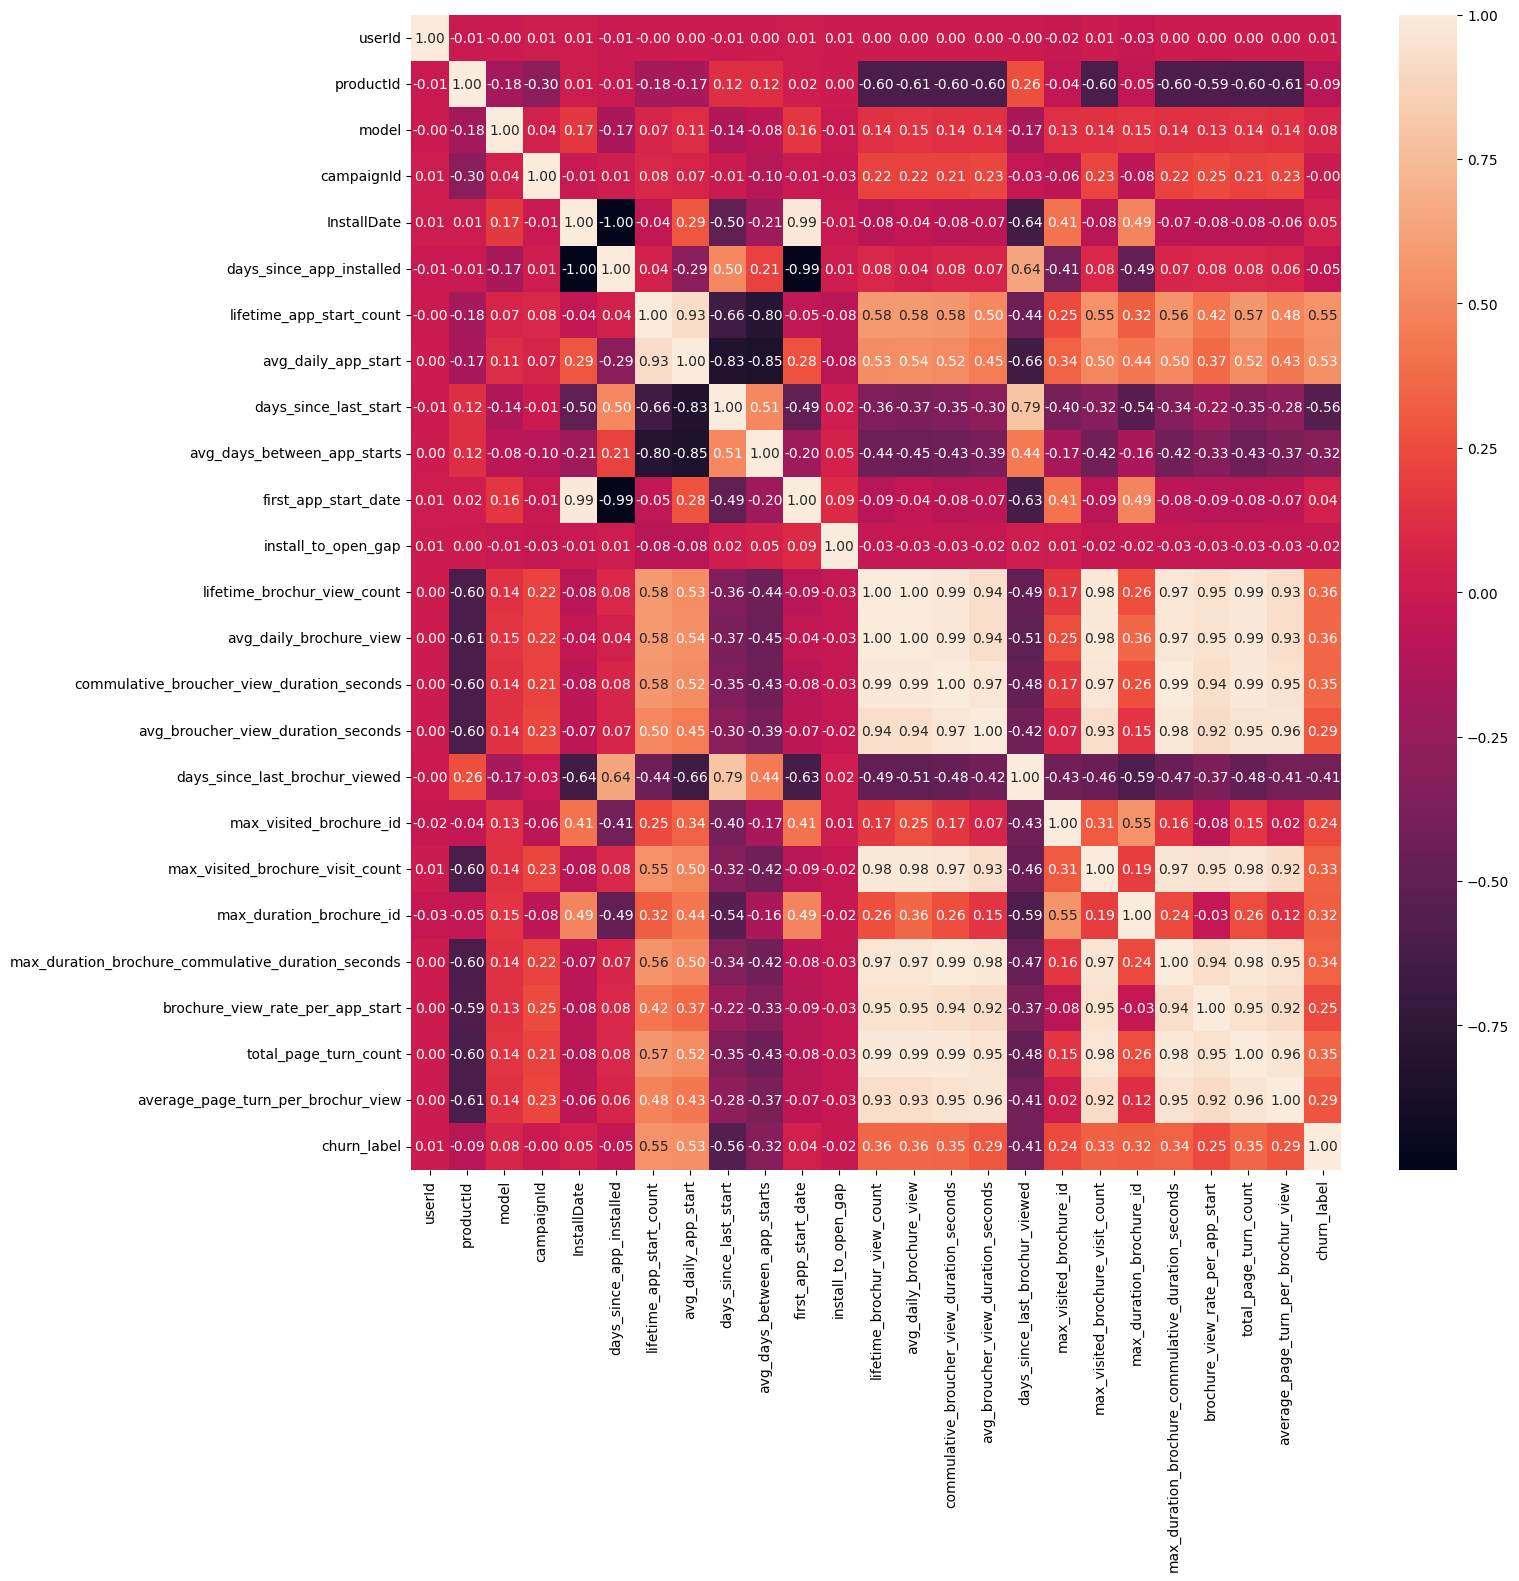

In [ ]:
df2 = df.copy()
le = LabelEncoder()
for col in df2.select_dtypes(include=['object']).columns:
    df2[col] = le.fit_transform(df2[col]).astype('float64')
plt.figure(figsize=(15, 15))  # Adjust size here
sns.heatmap(df2.corr(method='spearman',numeric_only=True), annot=True, fmt='.2f')
plt.show()

# we can remove correlated features Based on:
  # Interpretability: If one feature is easier to interpret or explain than the other, you might choose to keep it.
  # Relevance: If one feature is more relevant to your target variable (churn), you might choose to keep it.
  # Data Quality: If one feature has more reliable or complete data than the other, you might choose to keep it.
# hot correlinear features ['total_page_turn_count','max_duration_brochure_commulative_duration_seconds','max_visited_brochure_visit_count','brochure_view_rate_per_app_start','average_page_turn_per_brochur_view','userId','InstallDate','first_app_start_date','avg_daily_brochure_view','commulative_broucher_view_duration_seconds','avg_daily_app_start','avg_broucher_view_duration_seconds'], axis=1,inplace=True)

Insight: Correlation mostly existed in brochure related problem.
Let's check lifetime_borchure_view_count' distribution as this is the base of brochur features mostly.

In [ ]:
print('lifetime_borchure_view_count distribution \n{}'.format(df['lifetime_brochur_view_count'].value_counts()[:5]))

user count with 0 lifetime_borchur_view_count 
0.0    11500
1.0     1027
2.0      745
3.0      617
4.0      470
5.0      451
Name: lifetime_brochur_view_count, dtype: int64


**lifetime_borchur_view_count=0** is dominating the dataset.
As, most of other features are dependent on this, specially 0 value causing high correlation in matrix

Moreover, this creating bias in the dataset.

Hypothesis: lifetime_borchure_view_count=0 could very much mean churn.
Let's see

In [ ]:

print(df.value_counts(['lifetime_brochur_view_count','churn_label']))

lifetime_brochur_view_count  churn_label
0.0                          churn          9781
                             not_churn      1719
1.0                          churn           910
2.0                          churn           652
3.0                          churn           506
                                            ... 
91.0                         churn             1
171.0                        not_churn         1
169.0                        not_churn         1
95.0                         churn             1
659.0                        not_churn         1
Length: 393, dtype: int64


Yes, users with lifetime_borchure_view_count=0 mostly belong to churn class.

Now, let's see down sampling could help in Class balancing, removing bias and lower the correlation.

<ipython-input-36-3881387ed56b>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_df = df.drop(to_remove.index).append(to_keep)


(churn        5802
 not_churn    4917
 Name: churn_label, dtype: int64,
 <Axes: >)

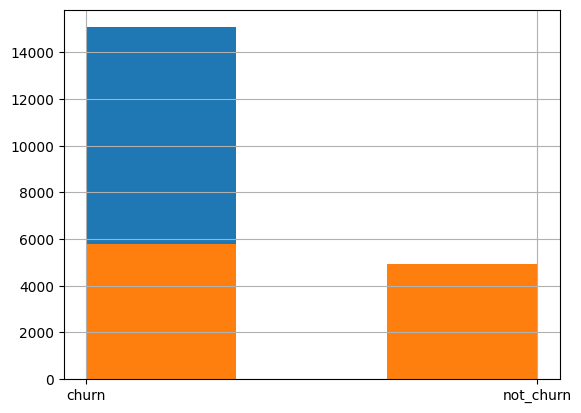

In [ ]:
df['churn_label'].hist(bins=3) # blue: without removal

# keeping a random sample of 500 from the entries with 0 brochur visits
to_remove = df[(df['lifetime_brochur_view_count'] == 0) & (df['churn_label'] == 'churn')]
to_keep = to_remove.sample(n=500)
filtered_df = df.drop(to_remove.index).append(to_keep)

filtered_df['churn_label'].value_counts(), filtered_df['churn_label'].hist(bins=3) # orange: without removal

As expected, class balance increased. Let's now check correlation.


(10719, 25)


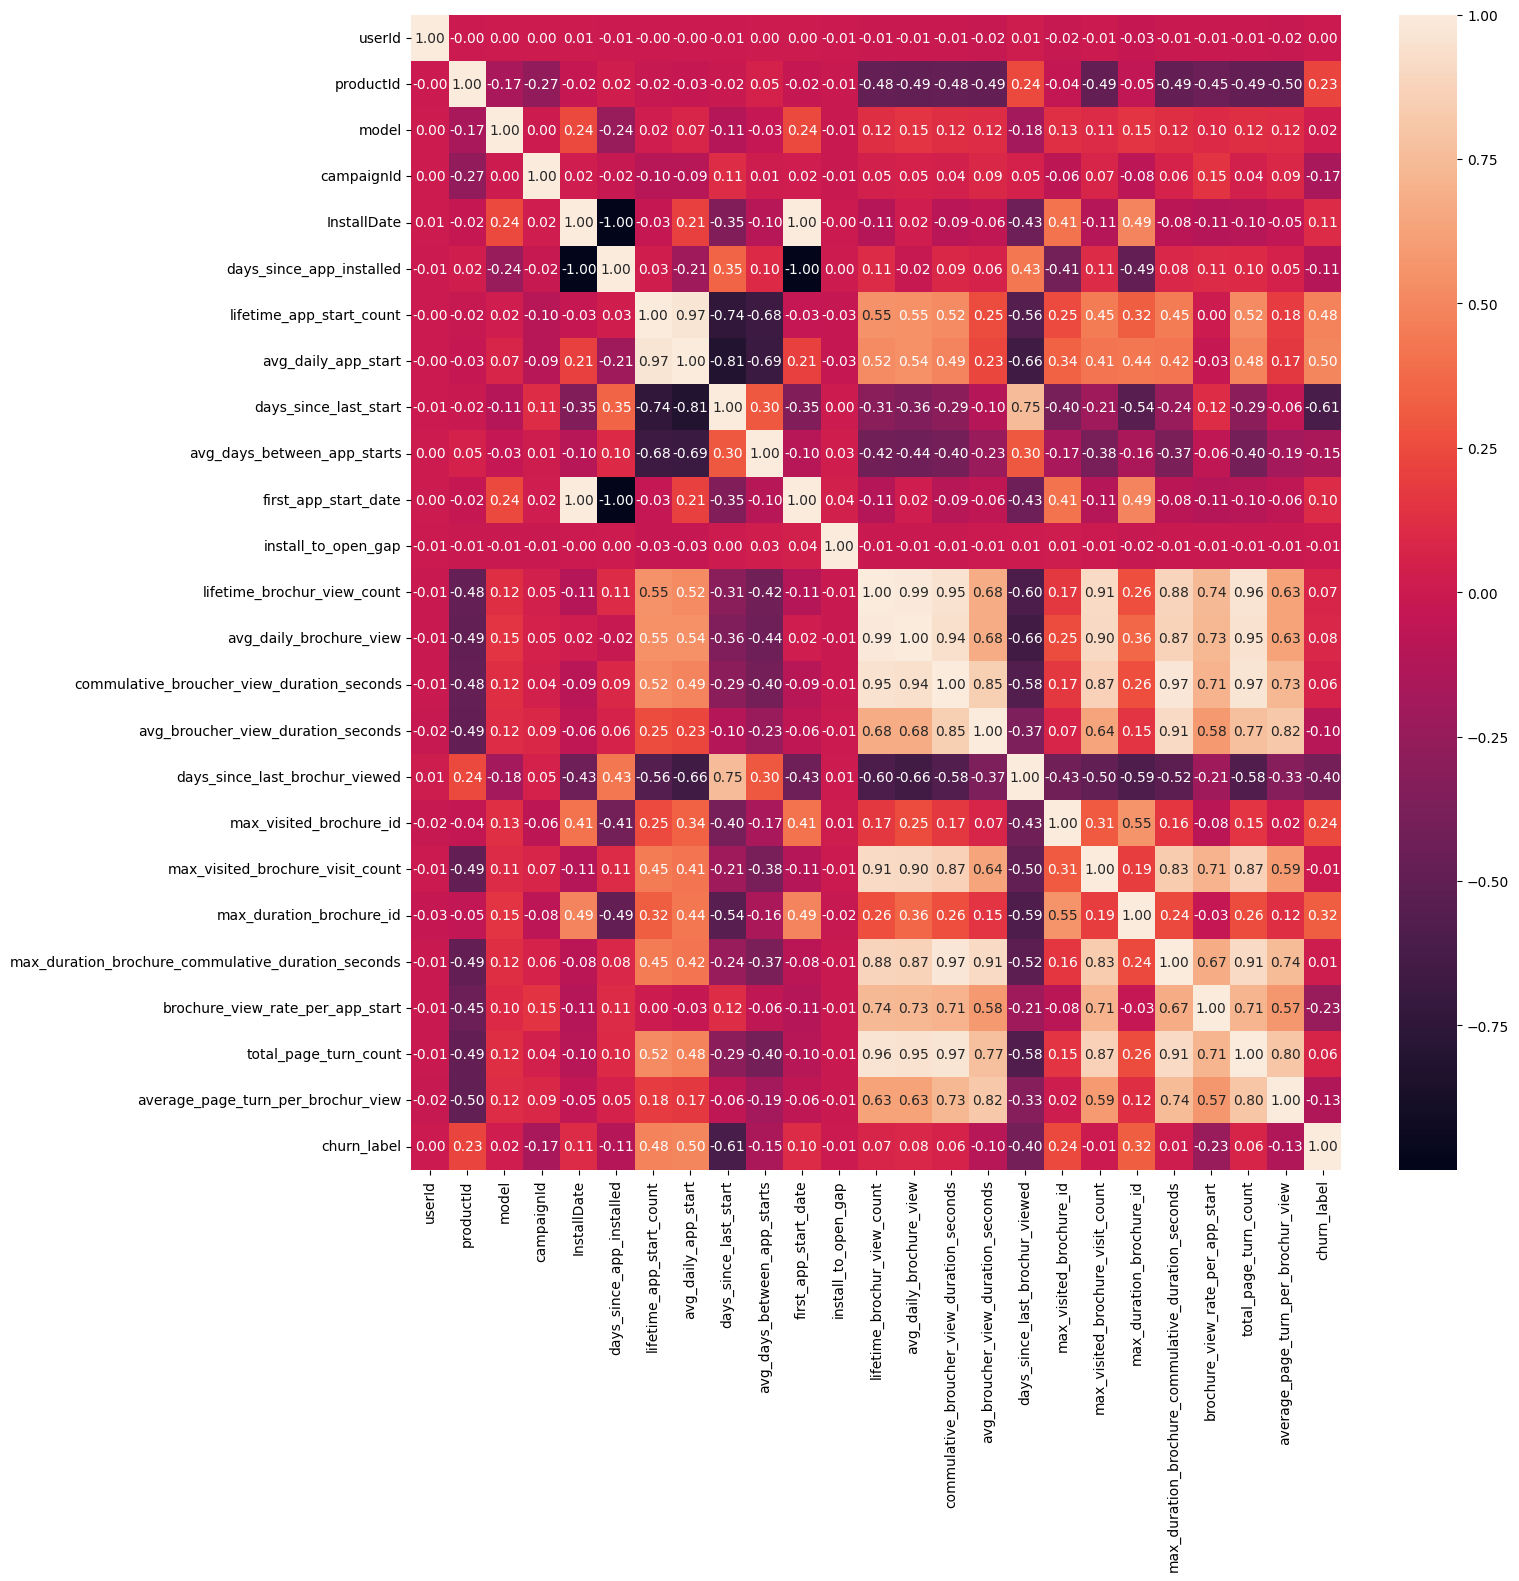

In [ ]:
df2 = filtered_df.copy()
# df2.drop(['max_visited_brochure_visit_count','total_page_turn_count','max_duration_brochure_commulative_duration_seconds','commulative_broucher_view_duration_seconds','avg_daily_brochure_view','avg_daily_app_start','first_app_start_date', 'userId','InstallDate'], axis=1,inplace=True)
print(df2.shape)
le = LabelEncoder()
for col in df2.select_dtypes(include=['object']).columns:
    df2[col] = le.fit_transform(df2[col]).astype('float64')
plt.figure(figsize=(15, 15))  # Adjust size here
sns.heatmap(df2.corr(method='spearman'), annot=True, fmt='.2f')
plt.show()

'''
Correlation also reduced significantly.
'''

# **Feature Engineering**

**Removing Features Based on:**


*   **Interpretability**: If one feature is easier to interpret or explain than the other, you might choose to keep it.
*   **Relevance**: If one feature is more relevant to your target variable (churn), you might choose to keep it.
*   **Data Quality:** If one feature has more reliable or complete data than the other, you might choose to keep it.

In [ ]:
# dropping features least contribution to label and extremely high correlation as discussed in EDA.
df.drop(['max_visited_brochure_visit_count','total_page_turn_count','max_duration_brochure_commulative_duration_seconds','commulative_broucher_view_duration_seconds','avg_daily_brochure_view','avg_daily_app_start','first_app_start_date', 'userId','InstallDate'], axis=1,inplace=True)

In [ ]:
# renaming columns
df.rename(columns={'productId':'product_id', 'model':'device_model', 'campaignId':'campaign_id',
'days_since_last_start':'days_since_last_app_start','install_to_open_gap':'install_to_app_start_days',
'days_since_last_brochur_viewed':'days_since_last_brochure_viewed'},inplace=True)

In [ ]:
# fill missing
df['max_visited_brochure_id'].fillna(-1, inplace=True)
df['max_duration_brochure_id'].fillna(-1, inplace=True)
df['device_model'].fillna('unknown',inplace=True)

# Replace infinite values with 0
df.replace([np.inf, -np.inf], 0, inplace=True)

In [ ]:
# fix data types
df['max_visited_brochure_id'] = df['max_visited_brochure_id'].astype('int')
df['max_duration_brochure_id'] = df['max_duration_brochure_id'].astype('int')

Down sampling to decrease correlation, class imbalance and data bias.

In [ ]:
# balacing data (removing bias)
to_remove = df[(df['lifetime_brochur_view_count'] == 0) & (df['churn_label'] == 'churn')]
to_keep = to_remove.sample(n=500)
df = df.drop(to_remove.index).append(to_keep)
df.shape

<ipython-input-42-27edd7bb8776>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.drop(to_remove.index).append(to_keep)


(10719, 16)

In [ ]:
# Data Encoding
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col]).astype('float64')

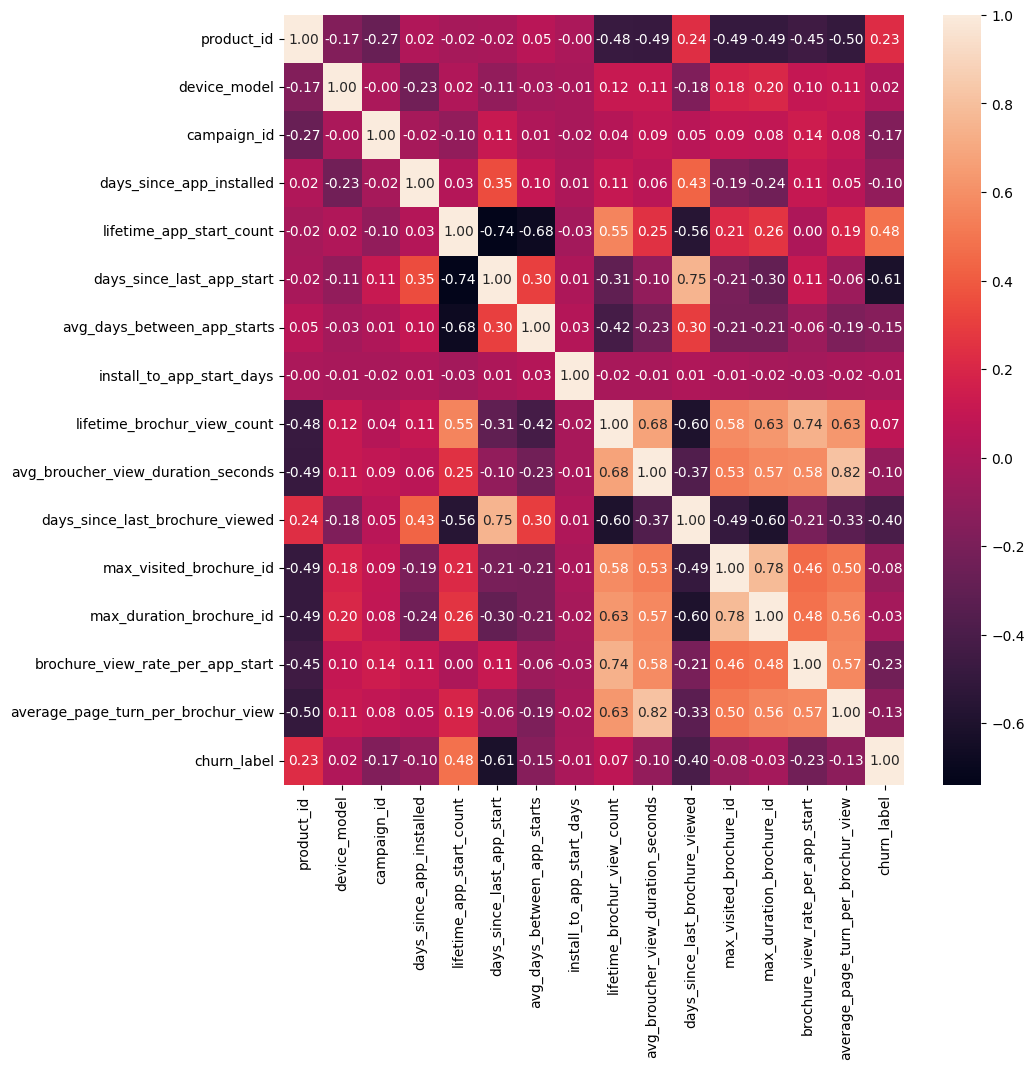

In [ ]:
plt.figure(figsize=(10, 10))  # Adjust size here
sns.heatmap(df.corr(method='spearman',numeric_only=True), annot=True, fmt='.2f')
plt.show()

In [ ]:
# from sklearn.feature_selection import RFE
# from sklearn.ensemble import RandomForestClassifier

# # Your data
# X = df.drop('churn_label', axis=1)
# y = df['churn_label']

# # Initialize model
# model = RandomForestClassifier()

# # Initialize RFE
# rfe = RFE(estimator=model, n_features_to_select=10)  # Choose the top 10 features

# # Fit RFE
# X_rfe = rfe.fit_transform(X, y)

# # Features ranking
# feature_ranking = pd.Series(rfe.ranking_, index=X.columns)

# # Top features
# top_features = X.columns[rfe.support_]
# print(top_features)

# **Preprocessing**

In [ ]:
# # Data normalization
# scaler = MinMaxScaler()

# # Select columns to scale
# columns_to_scale = df.columns

# df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [ ]:
# validation splitting
features = df.drop('churn_label', axis=1)
labels = df['churn_label']

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# **Training**

In [ ]:
# Initialize and train the model
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, random_state=42)

In [ ]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5, random_state=42)

In [ ]:
# Make predictions
y_pred = rf_clf.predict(X_val)
y_pred_proba = rf_clf.predict_proba(X_val)[:,1]

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)

print(f'Validation Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Validation Accuracy: 0.8432835820895522
F1 Score: 0.8271604938271604
ROC AUC Score: 0.9187504395527111


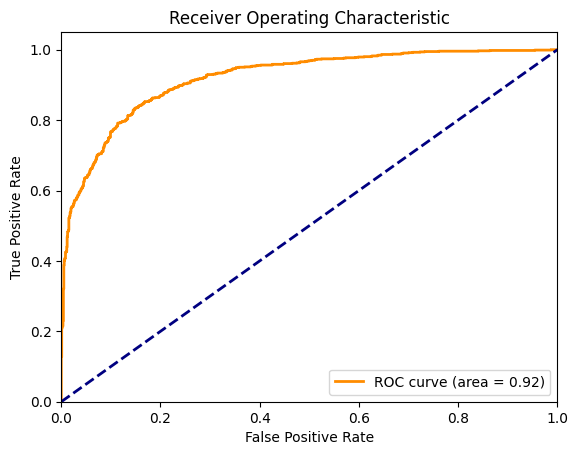

In [ ]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()